# 欠拟合和过拟合

## 多项式回归

我们通过多项式拟合来探索这些概念。

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定 $x$，使用以下三阶多项式来生成训练和测试数据的标签：$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$

噪声项 $\epsilon$ 服从均值为 0 且标准差为 0.1 的正态分布。

为训练集和测试集各生成 100 个样本。

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

同样，存储在 `poly_features` 中的单项式由gamma函数重新缩放，其中 $\Gamma(n)=(n-1)!$。
从生成的数据集中查看一下前 2 个样本，第一个值是与偏置相对应的常量特征。

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8663],
         [-0.2808]]),
 tensor([[ 1.0000e+00, -8.6634e-01,  3.7527e-01, -1.0837e-01,  2.3471e-02,
          -4.0669e-03,  5.8721e-04, -7.2675e-05,  7.8701e-06, -7.5758e-07,
           6.5632e-08, -5.1691e-09,  3.7318e-10, -2.4869e-11,  1.5389e-12,
          -8.8883e-14,  4.8127e-15, -2.4526e-16,  1.1804e-17, -5.3824e-19],
         [ 1.0000e+00, -2.8083e-01,  3.9432e-02, -3.6912e-03,  2.5915e-04,
          -1.4555e-05,  6.8125e-07, -2.7331e-08,  9.5940e-10, -2.9936e-11,
           8.4069e-13, -2.1463e-14,  5.0227e-16, -1.0850e-17,  2.1765e-19,
          -4.0747e-21,  7.1518e-23, -1.1814e-24,  1.8432e-26, -2.7243e-28]]),
 tensor([2.1291, 4.4734]))

### 对模型进行训练和测试

#### 损失函数定义
首先，实现一个函数来评估模型在给定数据集上的损失。

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

### 模型定义

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='mean')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合(正常)

首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值 $w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 5.006611   1.1860665 -3.4033365  5.620156 ]]


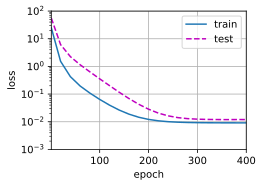

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(欠拟合)

再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[3.453544  3.8571358]]


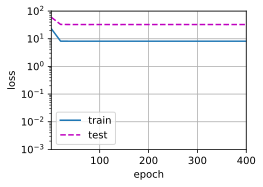

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合(过拟合)

现在，尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.9997025   1.260617   -3.37398     5.146686   -0.11076441  1.4814621
   0.2747469   0.05364268  0.19167101 -0.18782876 -0.21501584  0.20773543
  -0.14143467  0.02892069 -0.12898166  0.1579058  -0.0374513  -0.09900273
   0.20156384 -0.13878295]]


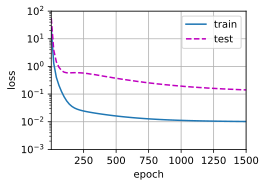

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)